In [1]:
import os
import cv2
import numpy as np
import core.utils as utils
import core.common_v4 as common
import core.backbone_v4 as backbone
import tensorflow as tf
# from core.yolov3 import YOLOv3, decode
from PIL import Image
from matplotlib import pyplot as plt
import random

In [2]:
def cspdarknet53(input_data):

    input_data = common.convolutional(input_data, (3, 3,  3,  32), activate_type="mish")
    input_data = common.convolutional(input_data, (3, 3, 32,  64), downsample=True, activate_type="mish")

    route = input_data
    route = common.convolutional(route, (1, 1, 64, 64), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 64, 64), activate_type="mish")
    for i in range(1):
        input_data = common.residual_block(input_data,  64,  32, 64, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 64, 64), activate_type="mish")

    input_data = tf.concat([input_data, route], axis=-1)
    input_data = common.convolutional(input_data, (1, 1, 128, 64), activate_type="mish")
    input_data = common.convolutional(input_data, (3, 3, 64, 128), downsample=True, activate_type="mish")
    route = input_data
    
    route = common.convolutional(route, (1, 1, 128, 64), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 128, 64), activate_type="mish")
    for i in range(2):
        input_data = common.residual_block(input_data, 64,  64, 64, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 64, 64), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 128, 128), activate_type="mish")
    
    fm200 = input_data
    
    input_data = common.convolutional(input_data, (3, 3, 128, 256), downsample=True, activate_type="mish")
    route = input_data   
    
    route = common.convolutional(route, (1, 1, 256, 128), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 256, 128), activate_type="mish")
    for i in range(8):
        input_data = common.residual_block(input_data, 128, 128, 128, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 128, 128), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 256, 256), activate_type="mish")
    
    route_1 = input_data
    
    input_data = common.convolutional(input_data, (3, 3, 256, 512), downsample=True, activate_type="mish")
    route = input_data
    route = common.convolutional(route, (1, 1, 512, 256), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 512, 256), activate_type="mish")
    for i in range(8):
        input_data = common.residual_block(input_data, 256, 256, 256, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 256, 256), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 512, 512), activate_type="mish")
    route_2 = input_data
    input_data = common.convolutional(input_data, (3, 3, 512, 1024), downsample=True, activate_type="mish")
    route = input_data
    route = common.convolutional(route, (1, 1, 1024, 512), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 1024, 512), activate_type="mish")
    for i in range(4):
        input_data = common.residual_block(input_data, 512, 512, 512, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 512, 512), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 1024, 1024), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 1024, 512))
    input_data = common.convolutional(input_data, (3, 3, 512, 1024))
    input_data = common.convolutional(input_data, (1, 1, 1024, 512))

    input_data = tf.concat([tf.nn.max_pool(input_data, ksize=13, padding='SAME', strides=1), tf.nn.max_pool(input_data, ksize=9, padding='SAME', strides=1)
                            , tf.nn.max_pool(input_data, ksize=5, padding='SAME', strides=1), input_data], axis=-1)
    input_data = common.convolutional(input_data, (1, 1, 2048, 512))
    input_data = common.convolutional(input_data, (3, 3, 512, 1024))
    input_data = common.convolutional(input_data, (1, 1, 1024, 512))

    return route_1, route_2, input_data, fm200

In [3]:
def YOLOv4_hint(input_layer, NUM_CLASS):
    route_1, route_2, conv, hint200 = cspdarknet53(input_layer)
    
    hint100 = route_1

    route = conv
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.upsample(conv)
    route_2 = common.convolutional(route_2, (1, 1, 512, 256))
    conv = tf.concat([route_2, conv], axis=-1)

    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)
    route_1 = common.convolutional(route_1, (1, 1, 256, 128))
    conv = tf.concat([route_1, conv], axis=-1)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))

    route_1 = conv
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = common.convolutional(conv, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(route_1, (3, 3, 128, 256), downsample=True)
    conv = tf.concat([conv, route_2], axis=-1)

    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = common.convolutional(conv, (1, 1, 512, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(route_2, (3, 3, 256, 512), downsample=True)
    conv = tf.concat([conv, route], axis=-1)

    conv = common.convolutional(conv, (1, 1, 1024, 512))
    conv = common.convolutional(conv, (3, 3, 512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024, 512))
    conv = common.convolutional(conv, (3, 3, 512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024, 512))

    conv = common.convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = common.convolutional(conv, (1, 1, 1024, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox, hint100, hint200]

In [4]:
input_size = 800
NUM_CLASS = 4

input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv4_hint(input_layer, NUM_CLASS)

In [5]:
def image_preprocess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

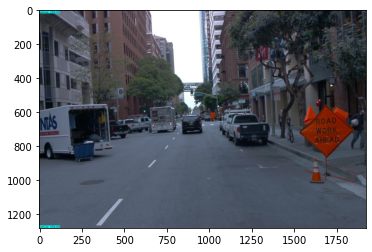

In [6]:
# image_path   = "./docs/bab97280-a3c6a37c.jpg"
image_path   = "./test.jpg"

img = plt.imread(image_path)
# plt.figure(figsize=(15,18))
plt.imshow(img)
plt.show()

In [7]:
original_image      = cv2.imread(image_path)
original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

print(image_data.shape)

(1, 800, 800, 3)


In [8]:
model = tf.keras.Model(input_layer, feature_maps)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 800, 800, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 800, 800, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.math.softplus (TFOpLambda)   (None, 800, 800, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
def load_weights(model, weights_file, model_name='yolov4', is_tiny=False):
    if is_tiny:
        if model_name == 'yolov3':
            layer_size = 13
            output_pos = [9, 12]
        else:
            layer_size = 21
            output_pos = [17, 20]
    else:
        if model_name == 'yolov3':
            layer_size = 75
            output_pos = [58, 66, 74]
        else:
            layer_size = 110
            output_pos = [93, 101, 109]
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    j = 0
    for i in range(layer_size):
        conv_layer_name = 'conv2d_%d' %i if i > 0 else 'conv2d'
        bn_layer_name = 'batch_normalization_%d' %j if j > 0 else 'batch_normalization'

        conv_layer = model.get_layer(conv_layer_name)
        filters = conv_layer.filters
        k_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]

        if i not in output_pos:
            # darknet weights: [beta, gamma, mean, variance]
            bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
            # tf weights: [gamma, beta, mean, variance]
            bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            bn_layer = model.get_layer(bn_layer_name)
            j += 1
        else:
            conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

        # darknet shape (out_dim, in_dim, height, width)
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

        if i not in output_pos:
            conv_layer.set_weights([conv_weights])
            bn_layer.set_weights(bn_weights)
        else:
            conv_layer.set_weights([conv_weights, conv_bias])

    # assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [10]:
model = tf.keras.Model(input_layer, feature_maps)
load_weights(model, './yolov4-waymo100k_800_best.weights')
# model.summary()

In [11]:
pred_bbox = model.predict(image_data)

In [12]:
print(len(pred_bbox))
hint = pred_bbox[3]
sample = pred_bbox[4]
print(hint.shape, sample.shape)
print(hint)

5
(1, 100, 100, 256) (1, 200, 200, 128)
[[[[ 0.54083025  1.9309341  -0.23502487 ...  0.97879946 -0.30525434
    -0.27995163]
   [ 1.9163222   2.4625652  -0.30790535 ... -0.2932774   1.3052392
    -0.1306784 ]
   [ 1.9699876   2.9635172  -0.21476574 ... -0.30138722  1.6178657
    -0.1072672 ]
   ...
   [ 1.5886357   3.2623632  -0.16031963 ... -0.3080553   1.2242036
    -0.08019342]
   [ 1.5487207   2.925078   -0.25651112 ... -0.19587086  0.4026955
    -0.06028182]
   [ 1.7195842   2.8700607  -0.22945684 ... -0.17412806 -0.27166048
    -0.1372102 ]]

  [[-0.03642542  0.382158    0.8338696  ...  2.3598135  -0.30808726
     1.6859225 ]
   [ 0.59641296  0.77780646 -0.18036957 ... -0.13115719 -0.29432598
    -0.10022748]
   [ 1.2869239  -0.01752394 -0.2422619  ... -0.11176743 -0.20010595
    -0.21596716]
   ...
   [ 0.68694854 -0.14477594 -0.20990717 ... -0.094859   -0.1739404
    -0.25660875]
   [ 0.50479436 -0.260251   -0.06780223 ... -0.02919602 -0.10929851
    -0.2946651 ]
   [ 0.4153942

82 (200, 200)


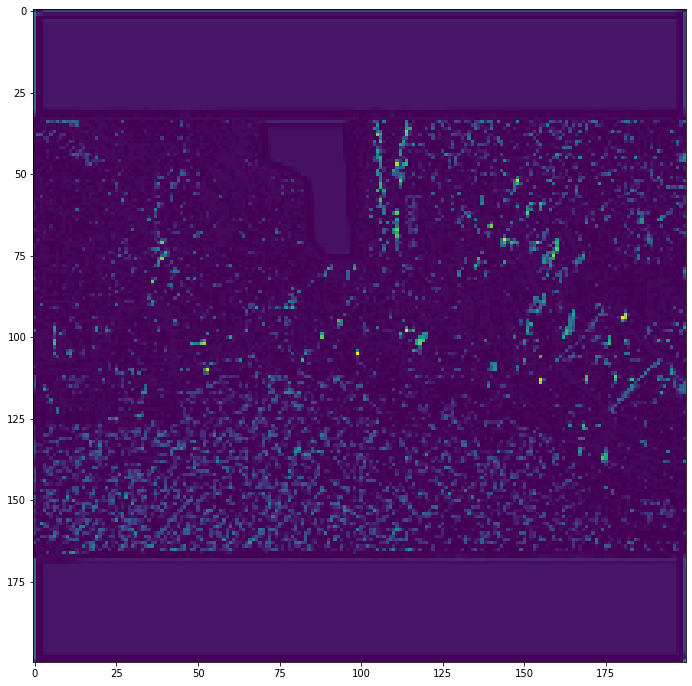

In [13]:
# 200x200
layer_th = random.randint(0,127)
one_channel = sample[0,:,:,layer_th]
print(layer_th, one_channel.shape)
plt.figure(figsize=(12,12))
plt.imshow(one_channel)
plt.show()

In [14]:
print(sample.shape)

(1, 200, 200, 128)


In [15]:
np.save('data.npy', sample) # save

In [16]:
new_num_arr = np.load('data.npy') # load

In [17]:
print(new_num_arr.shape)

(1, 200, 200, 128)


In [18]:
print(sample)

[[[[ 3.0983057  -0.30858594 -0.06428143 ...  3.9416215   1.688673
    -0.29306448]
   [ 3.0391896  -0.24277048  1.8159454  ...  4.083304    4.6355243
    -0.18275681]
   [ 3.417591   -0.11155767  3.2725537  ...  4.1984825   4.9344687
    -0.21546349]
   ...
   [ 4.036242   -0.09872591  4.084193   ...  3.961093    5.489102
    -0.28010088]
   [ 2.3837914  -0.07403805  5.301972   ...  4.052805    4.620467
    -0.23618244]
   [ 3.5609071  -0.05524095  4.8066874  ...  3.3129349   5.753436
    -0.23937452]]

  [[ 4.3383956  -0.287179   -0.12680233 ...  3.6957066   3.9968762
    -0.22194016]
   [ 1.0706886  -0.2611534  -0.250072   ...  3.209889    2.439628
    -0.303122  ]
   [-0.12258896 -0.18014199 -0.25578272 ...  2.2020316   1.2416807
    -0.15006879]
   ...
   [-0.28796533 -0.16889232 -0.2627267  ...  2.141766    1.0679822
    -0.13944189]
   [-0.2728626  -0.12984614  0.7530423  ...  2.1622853   0.48063052
    -0.11412144]
   [ 1.4485738  -0.21315207  3.2778008  ...  3.1256592   3.10186

In [19]:
print(new_num_arr)

[[[[ 3.0983057  -0.30858594 -0.06428143 ...  3.9416215   1.688673
    -0.29306448]
   [ 3.0391896  -0.24277048  1.8159454  ...  4.083304    4.6355243
    -0.18275681]
   [ 3.417591   -0.11155767  3.2725537  ...  4.1984825   4.9344687
    -0.21546349]
   ...
   [ 4.036242   -0.09872591  4.084193   ...  3.961093    5.489102
    -0.28010088]
   [ 2.3837914  -0.07403805  5.301972   ...  4.052805    4.620467
    -0.23618244]
   [ 3.5609071  -0.05524095  4.8066874  ...  3.3129349   5.753436
    -0.23937452]]

  [[ 4.3383956  -0.287179   -0.12680233 ...  3.6957066   3.9968762
    -0.22194016]
   [ 1.0706886  -0.2611534  -0.250072   ...  3.209889    2.439628
    -0.303122  ]
   [-0.12258896 -0.18014199 -0.25578272 ...  2.2020316   1.2416807
    -0.15006879]
   ...
   [-0.28796533 -0.16889232 -0.2627267  ...  2.141766    1.0679822
    -0.13944189]
   [-0.2728626  -0.12984614  0.7530423  ...  2.1622853   0.48063052
    -0.11412144]
   [ 1.4485738  -0.21315207  3.2778008  ...  3.1256592   3.10186

In [20]:
print(hint.shape)
print(hint)

(1, 100, 100, 256)
[[[[ 0.54083025  1.9309341  -0.23502487 ...  0.97879946 -0.30525434
    -0.27995163]
   [ 1.9163222   2.4625652  -0.30790535 ... -0.2932774   1.3052392
    -0.1306784 ]
   [ 1.9699876   2.9635172  -0.21476574 ... -0.30138722  1.6178657
    -0.1072672 ]
   ...
   [ 1.5886357   3.2623632  -0.16031963 ... -0.3080553   1.2242036
    -0.08019342]
   [ 1.5487207   2.925078   -0.25651112 ... -0.19587086  0.4026955
    -0.06028182]
   [ 1.7195842   2.8700607  -0.22945684 ... -0.17412806 -0.27166048
    -0.1372102 ]]

  [[-0.03642542  0.382158    0.8338696  ...  2.3598135  -0.30808726
     1.6859225 ]
   [ 0.59641296  0.77780646 -0.18036957 ... -0.13115719 -0.29432598
    -0.10022748]
   [ 1.2869239  -0.01752394 -0.2422619  ... -0.11176743 -0.20010595
    -0.21596716]
   ...
   [ 0.68694854 -0.14477594 -0.20990717 ... -0.094859   -0.1739404
    -0.25660875]
   [ 0.50479436 -0.260251   -0.06780223 ... -0.02919602 -0.10929851
    -0.2946651 ]
   [ 0.41539422  2.8662715  -0.0533

43 (100, 100)


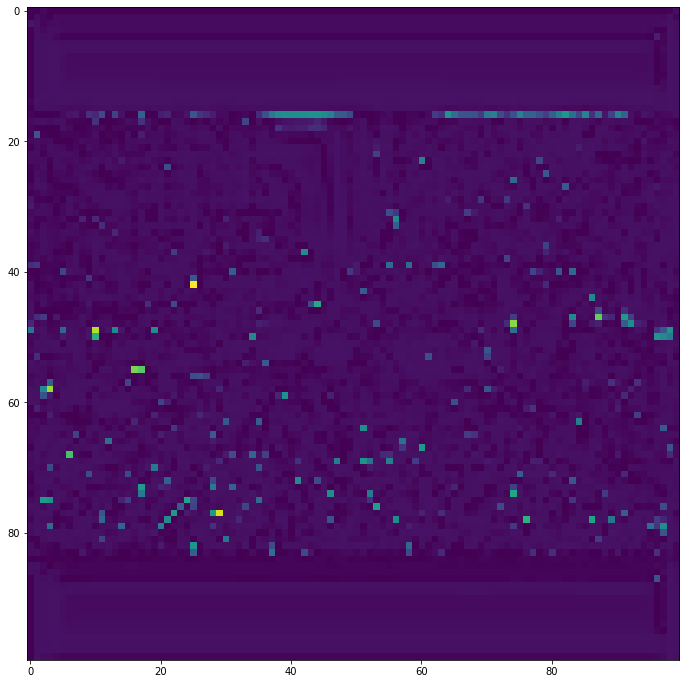

In [21]:
# 100x100
layer_th = random.randint(0,255)
one_channel = hint[0,:,:,layer_th]
print(layer_th, one_channel.shape)
plt.figure(figsize=(12,12))
plt.imshow(one_channel)
plt.show()

# Save Hint

In [25]:
import glob

In [27]:
def get_file_name(path):
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [(x.strip()).split() for x in content]
    return content

In [28]:
data_path = "./data/dataset/waymo_train.txt"
dataset = file_lines_to_list(data_path)
print(len(dataset))

65454


In [35]:
filenames = []

for i in range(len(dataset)):
    data = dataset[i]
    fname = get_file_name(data[0])
    filenames.append(fname)
    print(i, fname)

0 tr23-19-11-4-SIDE_LEFT
1 tr11-25-8-2-FRONT_LEFT
2 tr25-19-7-5-SIDE_RIGHT
3 tr29-13-3-1-FRONT
4 tr07-12-14-5-SIDE_RIGHT
5 tr28-17-13-5-SIDE_RIGHT
6 tr16-20-3-4-SIDE_LEFT
7 tr27-25-3-1-FRONT
8 tr29-9-1-1-FRONT
9 tr25-24-10-2-FRONT_LEFT
10 tr10-19-10-1-FRONT
11 tr01-20-2-2-FRONT_LEFT
12 tr11-14-14-1-FRONT
13 tr04-19-4-1-FRONT
14 tr23-10-13-4-SIDE_LEFT
15 tr23-2-20-2-FRONT_LEFT
16 tr29-8-17-5-SIDE_RIGHT
17 tr27-15-17-4-SIDE_LEFT
18 tr25-6-8-2-FRONT_LEFT
19 tr15-14-1-5-SIDE_RIGHT
20 tr24-5-17-1-FRONT
21 tr21-24-7-4-SIDE_LEFT
22 tr09-18-18-1-FRONT
23 tr11-25-5-4-SIDE_LEFT
24 tr20-25-15-3-FRONT_RIGHT
25 tr01-4-9-5-SIDE_RIGHT
26 tr28-22-9-1-FRONT
27 tr28-12-4-1-FRONT
28 tr16-7-6-1-FRONT
29 tr22-19-19-2-FRONT_LEFT
30 tr04-4-16-1-FRONT
31 tr15-7-16-1-FRONT
32 tr30-2-6-1-FRONT
33 tr13-4-8-4-SIDE_LEFT
34 tr14-10-11-3-FRONT_RIGHT
35 tr19-16-9-4-SIDE_LEFT
36 tr12-8-15-5-SIDE_RIGHT
37 tr08-22-2-1-FRONT
38 tr14-9-5-4-SIDE_LEFT
39 tr08-19-3-1-FRONT
40 tr03-18-12-2-FRONT_LEFT
41 tr06-13-18-5-SIDE_RIGH

1782 tr05-22-19-4-SIDE_LEFT
1783 tr21-6-9-4-SIDE_LEFT
1784 tr24-1-14-1-FRONT
1785 tr16-11-13-3-FRONT_RIGHT
1786 tr14-24-6-4-SIDE_LEFT
1787 tr13-2-17-5-SIDE_RIGHT
1788 tr17-13-5-3-FRONT_RIGHT
1789 tr02-5-6-5-SIDE_RIGHT
1790 tr02-5-15-2-FRONT_LEFT
1791 tr17-2-6-4-SIDE_LEFT
1792 tr17-4-9-5-SIDE_RIGHT
1793 tr23-25-14-3-FRONT_RIGHT
1794 tr10-9-14-2-FRONT_LEFT
1795 tr05-7-6-1-FRONT
1796 tr29-20-10-2-FRONT_LEFT
1797 tr04-7-9-1-FRONT
1798 tr28-5-18-3-FRONT_RIGHT
1799 tr30-11-6-2-FRONT_LEFT
1800 tr08-18-20-2-FRONT_LEFT
1801 tr26-24-4-3-FRONT_RIGHT
1802 tr25-5-1-5-SIDE_RIGHT
1803 tr13-5-20-4-SIDE_LEFT
1804 tr10-6-17-4-SIDE_LEFT
1805 tr27-6-20-5-SIDE_RIGHT
1806 tr26-17-3-3-FRONT_RIGHT
1807 tr10-24-6-2-FRONT_LEFT
1808 tr23-22-9-2-FRONT_LEFT
1809 tr20-18-2-1-FRONT
1810 tr31-9-20-5-SIDE_RIGHT
1811 tr01-1-3-5-SIDE_RIGHT
1812 tr15-15-17-2-FRONT_LEFT
1813 tr06-6-11-5-SIDE_RIGHT
1814 tr19-15-8-3-FRONT_RIGHT
1815 tr05-15-15-1-FRONT
1816 tr07-9-15-1-FRONT
1817 tr05-25-13-4-SIDE_LEFT
1818 tr10-1-4-1-FRONT


3532 tr00-18-4-4-SIDE_LEFT
3533 tr31-2-8-2-FRONT_LEFT
3534 tr20-3-20-3-FRONT_RIGHT
3535 tr25-10-8-2-FRONT_LEFT
3536 tr25-15-15-2-FRONT_LEFT
3537 tr05-12-7-1-FRONT
3538 tr00-2-16-2-FRONT_LEFT
3539 tr06-3-12-5-SIDE_RIGHT
3540 tr17-7-19-1-FRONT
3541 tr26-20-7-2-FRONT_LEFT
3542 tr17-3-16-3-FRONT_RIGHT
3543 tr08-16-4-4-SIDE_LEFT
3544 tr00-24-11-4-SIDE_LEFT
3545 tr28-6-4-1-FRONT
3546 tr28-19-3-3-FRONT_RIGHT
3547 tr22-1-2-2-FRONT_LEFT
3548 tr01-1-19-3-FRONT_RIGHT
3549 tr02-12-11-1-FRONT
3550 tr08-18-1-3-FRONT_RIGHT
3551 tr17-3-18-1-FRONT
3552 tr06-4-15-3-FRONT_RIGHT
3553 tr11-15-11-3-FRONT_RIGHT
3554 tr21-19-7-4-SIDE_LEFT
3555 tr23-5-14-1-FRONT
3556 tr18-15-18-5-SIDE_RIGHT
3557 tr30-22-6-5-SIDE_RIGHT
3558 tr23-12-6-3-FRONT_RIGHT
3559 tr22-12-9-3-FRONT_RIGHT
3560 tr13-25-1-5-SIDE_RIGHT
3561 tr06-21-6-2-FRONT_LEFT
3562 tr12-24-16-5-SIDE_RIGHT
3563 tr16-22-12-2-FRONT_LEFT
3564 tr06-24-8-3-FRONT_RIGHT
3565 tr29-2-1-1-FRONT
3566 tr31-6-7-3-FRONT_RIGHT
3567 tr05-18-17-4-SIDE_LEFT
3568 tr25-2-9-1-FR

5531 tr14-20-12-4-SIDE_LEFT
5532 tr21-12-20-4-SIDE_LEFT
5533 tr30-13-7-1-FRONT
5534 tr00-16-10-5-SIDE_RIGHT
5535 tr07-7-8-4-SIDE_LEFT
5536 tr15-24-17-5-SIDE_RIGHT
5537 tr02-19-2-3-FRONT_RIGHT
5538 tr01-12-8-4-SIDE_LEFT
5539 tr02-14-15-2-FRONT_LEFT
5540 tr14-20-10-4-SIDE_LEFT
5541 tr27-13-11-3-FRONT_RIGHT
5542 tr28-23-2-2-FRONT_LEFT
5543 tr00-8-4-3-FRONT_RIGHT
5544 tr17-22-15-2-FRONT_LEFT
5545 tr11-3-1-5-SIDE_RIGHT
5546 tr18-12-13-2-FRONT_LEFT
5547 tr12-11-5-5-SIDE_RIGHT
5548 tr31-23-8-2-FRONT_LEFT
5549 tr25-24-16-2-FRONT_LEFT
5550 tr12-8-4-2-FRONT_LEFT
5551 tr01-7-8-1-FRONT
5552 tr15-18-8-3-FRONT_RIGHT
5553 tr01-2-20-1-FRONT
5554 tr05-24-8-2-FRONT_LEFT
5555 tr05-19-1-3-FRONT_RIGHT
5556 tr17-24-8-2-FRONT_LEFT
5557 tr26-7-4-5-SIDE_RIGHT
5558 tr14-16-4-4-SIDE_LEFT
5559 tr31-19-6-3-FRONT_RIGHT
5560 tr29-16-9-3-FRONT_RIGHT
5561 tr23-20-5-3-FRONT_RIGHT
5562 tr18-22-4-1-FRONT
5563 tr12-12-1-1-FRONT
5564 tr08-1-7-2-FRONT_LEFT
5565 tr27-18-3-2-FRONT_LEFT
5566 tr26-13-7-2-FRONT_LEFT
5567 tr17-13

7362 tr06-1-2-2-FRONT_LEFT
7363 tr27-1-16-3-FRONT_RIGHT
7364 tr11-7-3-2-FRONT_LEFT
7365 tr09-2-7-1-FRONT
7366 tr04-5-7-3-FRONT_RIGHT
7367 tr13-15-13-4-SIDE_LEFT
7368 tr02-8-8-1-FRONT
7369 tr16-1-2-5-SIDE_RIGHT
7370 tr26-8-11-3-FRONT_RIGHT
7371 tr27-5-9-4-SIDE_LEFT
7372 tr19-1-1-4-SIDE_LEFT
7373 tr02-6-15-1-FRONT
7374 tr18-21-7-1-FRONT
7375 tr10-19-14-3-FRONT_RIGHT
7376 tr20-5-1-3-FRONT_RIGHT
7377 tr31-24-7-1-FRONT
7378 tr30-2-16-5-SIDE_RIGHT
7379 tr09-12-7-5-SIDE_RIGHT
7380 tr07-1-18-1-FRONT
7381 tr03-25-12-1-FRONT
7382 tr02-21-13-2-FRONT_LEFT
7383 tr14-11-17-4-SIDE_LEFT
7384 tr07-19-16-5-SIDE_RIGHT
7385 tr02-1-17-1-FRONT
7386 tr15-1-16-1-FRONT
7387 tr27-3-5-2-FRONT_LEFT
7388 tr23-2-12-5-SIDE_RIGHT
7389 tr03-12-18-4-SIDE_LEFT
7390 tr02-18-15-4-SIDE_LEFT
7391 tr04-4-12-2-FRONT_LEFT
7392 tr15-21-2-1-FRONT
7393 tr27-1-4-1-FRONT
7394 tr27-6-13-4-SIDE_LEFT
7395 tr25-10-3-4-SIDE_LEFT
7396 tr23-2-5-4-SIDE_LEFT
7397 tr04-18-19-3-FRONT_RIGHT
7398 tr31-19-15-3-FRONT_RIGHT
7399 tr14-2-2-1-FRONT
7

9281 tr03-1-19-1-FRONT
9282 tr20-24-1-4-SIDE_LEFT
9283 tr24-22-10-5-SIDE_RIGHT
9284 tr24-20-11-1-FRONT
9285 tr18-11-10-2-FRONT_LEFT
9286 tr30-20-20-2-FRONT_LEFT
9287 tr09-16-8-2-FRONT_LEFT
9288 tr29-5-7-4-SIDE_LEFT
9289 tr27-20-12-4-SIDE_LEFT
9290 tr24-22-8-1-FRONT
9291 tr25-5-5-1-FRONT
9292 tr07-8-16-2-FRONT_LEFT
9293 tr18-5-5-2-FRONT_LEFT
9294 tr18-18-18-5-SIDE_RIGHT
9295 tr04-12-17-2-FRONT_LEFT
9296 tr21-2-14-1-FRONT
9297 tr29-4-9-1-FRONT
9298 tr27-9-8-1-FRONT
9299 tr16-25-20-4-SIDE_LEFT
9300 tr09-23-18-1-FRONT
9301 tr31-23-5-2-FRONT_LEFT
9302 tr11-18-17-1-FRONT
9303 tr22-21-10-5-SIDE_RIGHT
9304 tr19-11-15-3-FRONT_RIGHT
9305 tr08-24-17-1-FRONT
9306 tr00-11-6-2-FRONT_LEFT
9307 tr21-22-11-5-SIDE_RIGHT
9308 tr08-2-16-5-SIDE_RIGHT
9309 tr29-11-14-2-FRONT_LEFT
9310 tr27-2-8-2-FRONT_LEFT
9311 tr03-2-4-2-FRONT_LEFT
9312 tr20-4-7-5-SIDE_RIGHT
9313 tr22-12-15-4-SIDE_LEFT
9314 tr17-17-3-4-SIDE_LEFT
9315 tr09-21-20-4-SIDE_LEFT
9316 tr28-6-13-5-SIDE_RIGHT
9317 tr31-12-15-3-FRONT_RIGHT
9318 tr16

11031 tr30-4-9-5-SIDE_RIGHT
11032 tr11-17-2-4-SIDE_LEFT
11033 tr30-4-13-1-FRONT
11034 tr01-13-8-1-FRONT
11035 tr10-23-18-1-FRONT
11036 tr10-25-11-4-SIDE_LEFT
11037 tr06-9-5-1-FRONT
11038 tr22-20-15-4-SIDE_LEFT
11039 tr02-1-20-1-FRONT
11040 tr17-12-16-4-SIDE_LEFT
11041 tr05-10-20-2-FRONT_LEFT
11042 tr02-25-10-5-SIDE_RIGHT
11043 tr04-20-5-1-FRONT
11044 tr24-13-3-5-SIDE_RIGHT
11045 tr21-13-4-3-FRONT_RIGHT
11046 tr18-21-1-5-SIDE_RIGHT
11047 tr26-10-12-4-SIDE_LEFT
11048 tr10-21-9-1-FRONT
11049 tr00-16-1-2-FRONT_LEFT
11050 tr00-10-15-2-FRONT_LEFT
11051 tr07-21-9-4-SIDE_LEFT
11052 tr23-4-17-4-SIDE_LEFT
11053 tr23-19-10-1-FRONT
11054 tr10-14-7-1-FRONT
11055 tr02-16-17-1-FRONT
11056 tr15-13-4-3-FRONT_RIGHT
11057 tr12-3-4-5-SIDE_RIGHT
11058 tr13-6-9-1-FRONT
11059 tr22-17-3-4-SIDE_LEFT
11060 tr24-14-3-3-FRONT_RIGHT
11061 tr02-22-10-4-SIDE_LEFT
11062 tr27-8-17-4-SIDE_LEFT
11063 tr28-18-1-4-SIDE_LEFT
11064 tr03-4-2-5-SIDE_RIGHT
11065 tr17-16-16-1-FRONT
11066 tr19-22-12-5-SIDE_RIGHT
11067 tr09-23-20

13030 tr29-21-3-2-FRONT_LEFT
13031 tr15-13-5-4-SIDE_LEFT
13032 tr13-23-9-3-FRONT_RIGHT
13033 tr26-17-1-2-FRONT_LEFT
13034 tr23-13-12-5-SIDE_RIGHT
13035 tr04-7-3-2-FRONT_LEFT
13036 tr13-9-12-5-SIDE_RIGHT
13037 tr22-22-13-1-FRONT
13038 tr12-5-9-4-SIDE_LEFT
13039 tr17-25-19-1-FRONT
13040 tr16-6-18-2-FRONT_LEFT
13041 tr06-24-19-1-FRONT
13042 tr29-8-6-1-FRONT
13043 tr00-2-18-3-FRONT_RIGHT
13044 tr13-21-5-1-FRONT
13045 tr17-20-15-2-FRONT_LEFT
13046 tr16-6-10-3-FRONT_RIGHT
13047 tr14-18-4-2-FRONT_LEFT
13048 tr06-5-10-3-FRONT_RIGHT
13049 tr21-25-13-1-FRONT
13050 tr17-13-3-1-FRONT
13051 tr20-6-11-1-FRONT
13052 tr16-3-10-3-FRONT_RIGHT
13053 tr05-5-17-2-FRONT_LEFT
13054 tr12-20-4-4-SIDE_LEFT
13055 tr17-8-5-5-SIDE_RIGHT
13056 tr03-11-11-4-SIDE_LEFT
13057 tr23-12-15-5-SIDE_RIGHT
13058 tr19-17-20-1-FRONT
13059 tr17-20-10-3-FRONT_RIGHT
13060 tr03-18-15-5-SIDE_RIGHT
13061 tr04-3-7-1-FRONT
13062 tr13-16-9-4-SIDE_LEFT
13063 tr28-18-8-1-FRONT
13064 tr22-15-19-5-SIDE_RIGHT
13065 tr15-24-20-2-FRONT_LEFT
13

15030 tr05-7-6-3-FRONT_RIGHT
15031 tr03-8-16-5-SIDE_RIGHT
15032 tr03-7-16-1-FRONT
15033 tr20-10-10-2-FRONT_LEFT
15034 tr27-12-13-5-SIDE_RIGHT
15035 tr20-3-13-4-SIDE_LEFT
15036 tr19-4-19-4-SIDE_LEFT
15037 tr16-5-12-5-SIDE_RIGHT
15038 tr00-22-12-1-FRONT
15039 tr26-5-7-1-FRONT
15040 tr08-17-5-4-SIDE_LEFT
15041 tr02-6-13-5-SIDE_RIGHT
15042 tr21-6-15-1-FRONT
15043 tr28-19-14-3-FRONT_RIGHT
15044 tr24-23-19-3-FRONT_RIGHT
15045 tr14-25-5-4-SIDE_LEFT
15046 tr00-21-6-1-FRONT
15047 tr06-10-9-4-SIDE_LEFT
15048 tr00-8-5-5-SIDE_RIGHT
15049 tr16-25-9-3-FRONT_RIGHT
15050 tr26-3-3-5-SIDE_RIGHT
15051 tr10-4-8-3-FRONT_RIGHT
15052 tr01-10-9-5-SIDE_RIGHT
15053 tr09-2-15-5-SIDE_RIGHT
15054 tr17-19-1-4-SIDE_LEFT
15055 tr29-11-4-5-SIDE_RIGHT
15056 tr03-19-19-1-FRONT
15057 tr25-24-8-1-FRONT
15058 tr02-18-10-2-FRONT_LEFT
15059 tr06-17-5-5-SIDE_RIGHT
15060 tr11-11-2-5-SIDE_RIGHT
15061 tr04-12-19-4-SIDE_LEFT
15062 tr29-14-18-4-SIDE_LEFT
15063 tr28-3-18-1-FRONT
15064 tr27-20-14-3-FRONT_RIGHT
15065 tr13-5-13-4-SIDE

16878 tr12-15-16-1-FRONT
16879 tr25-25-13-4-SIDE_LEFT
16880 tr01-9-18-1-FRONT
16881 tr00-9-20-3-FRONT_RIGHT
16882 tr23-13-6-4-SIDE_LEFT
16883 tr24-21-12-1-FRONT
16884 tr27-6-6-2-FRONT_LEFT
16885 tr30-24-9-2-FRONT_LEFT
16886 tr22-8-11-2-FRONT_LEFT
16887 tr16-20-1-5-SIDE_RIGHT
16888 tr01-8-4-5-SIDE_RIGHT
16889 tr11-11-9-5-SIDE_RIGHT
16890 tr00-19-3-4-SIDE_LEFT
16891 tr28-6-6-5-SIDE_RIGHT
16892 tr08-23-14-1-FRONT
16893 tr26-21-3-5-SIDE_RIGHT
16894 tr02-5-20-1-FRONT
16895 tr27-20-5-2-FRONT_LEFT
16896 tr22-8-20-5-SIDE_RIGHT
16897 tr23-20-11-4-SIDE_LEFT
16898 tr11-6-5-4-SIDE_LEFT
16899 tr26-23-14-3-FRONT_RIGHT
16900 tr20-7-9-1-FRONT
16901 tr24-20-12-5-SIDE_RIGHT
16902 tr31-21-12-4-SIDE_LEFT
16903 tr23-1-17-2-FRONT_LEFT
16904 tr26-5-9-2-FRONT_LEFT
16905 tr20-24-11-1-FRONT
16906 tr23-8-15-4-SIDE_LEFT
16907 tr13-18-4-2-FRONT_LEFT
16908 tr23-11-16-1-FRONT
16909 tr22-15-20-3-FRONT_RIGHT
16910 tr30-18-11-3-FRONT_RIGHT
16911 tr26-16-2-2-FRONT_LEFT
16912 tr10-1-9-2-FRONT_LEFT
16913 tr08-1-9-5-SIDE_R

18780 tr18-13-8-4-SIDE_LEFT
18781 tr09-22-13-3-FRONT_RIGHT
18782 tr13-4-18-1-FRONT
18783 tr09-6-10-2-FRONT_LEFT
18784 tr25-8-18-4-SIDE_LEFT
18785 tr02-16-7-1-FRONT
18786 tr29-21-15-5-SIDE_RIGHT
18787 tr02-2-18-4-SIDE_LEFT
18788 tr28-21-14-1-FRONT
18789 tr06-5-14-4-SIDE_LEFT
18790 tr02-18-2-5-SIDE_RIGHT
18791 tr19-8-1-2-FRONT_LEFT
18792 tr08-17-8-1-FRONT
18793 tr30-16-1-4-SIDE_LEFT
18794 tr22-21-13-1-FRONT
18795 tr02-20-8-3-FRONT_RIGHT
18796 tr22-20-1-1-FRONT
18797 tr03-7-19-5-SIDE_RIGHT
18798 tr14-2-8-1-FRONT
18799 tr31-23-17-4-SIDE_LEFT
18800 tr19-21-8-1-FRONT
18801 tr21-15-7-2-FRONT_LEFT
18802 tr21-24-15-4-SIDE_LEFT
18803 tr01-9-3-4-SIDE_LEFT
18804 tr11-10-16-4-SIDE_LEFT
18805 tr18-17-15-3-FRONT_RIGHT
18806 tr00-11-3-4-SIDE_LEFT
18807 tr00-5-3-1-FRONT
18808 tr06-19-6-4-SIDE_LEFT
18809 tr26-21-5-1-FRONT
18810 tr28-12-20-2-FRONT_LEFT
18811 tr24-13-1-2-FRONT_LEFT
18812 tr03-10-4-3-FRONT_RIGHT
18813 tr29-21-14-3-FRONT_RIGHT
18814 tr04-17-20-1-FRONT
18815 tr31-21-10-3-FRONT_RIGHT
18816 tr

20745 tr08-23-7-3-FRONT_RIGHT
20746 tr24-15-6-2-FRONT_LEFT
20747 tr14-19-2-5-SIDE_RIGHT
20748 tr28-22-6-5-SIDE_RIGHT
20749 tr30-22-15-1-FRONT
20750 tr04-11-11-1-FRONT
20751 tr26-14-15-1-FRONT
20752 tr00-2-1-3-FRONT_RIGHT
20753 tr23-14-18-2-FRONT_LEFT
20754 tr03-21-7-1-FRONT
20755 tr22-21-1-3-FRONT_RIGHT
20756 tr10-6-15-2-FRONT_LEFT
20757 tr18-8-4-1-FRONT
20758 tr06-25-20-3-FRONT_RIGHT
20759 tr01-18-8-4-SIDE_LEFT
20760 tr01-1-5-4-SIDE_LEFT
20761 tr11-3-2-1-FRONT
20762 tr15-25-17-5-SIDE_RIGHT
20763 tr11-21-17-4-SIDE_LEFT
20764 tr04-3-9-4-SIDE_LEFT
20765 tr06-19-11-2-FRONT_LEFT
20766 tr19-13-12-3-FRONT_RIGHT
20767 tr08-24-4-2-FRONT_LEFT
20768 tr30-4-2-5-SIDE_RIGHT
20769 tr21-6-1-5-SIDE_RIGHT
20770 tr08-25-3-2-FRONT_LEFT
20771 tr31-14-20-5-SIDE_RIGHT
20772 tr08-20-11-2-FRONT_LEFT
20773 tr30-23-4-3-FRONT_RIGHT
20774 tr15-5-18-4-SIDE_LEFT
20775 tr13-23-12-5-SIDE_RIGHT
20776 tr02-1-7-2-FRONT_LEFT
20777 tr05-16-17-1-FRONT
20778 tr14-20-1-4-SIDE_LEFT
20779 tr20-24-20-3-FRONT_RIGHT
20780 tr07-13

22529 tr19-8-9-5-SIDE_RIGHT
22530 tr12-11-3-5-SIDE_RIGHT
22531 tr03-17-3-2-FRONT_LEFT
22532 tr25-3-9-1-FRONT
22533 tr19-2-5-2-FRONT_LEFT
22534 tr01-11-13-1-FRONT
22535 tr16-4-8-5-SIDE_RIGHT
22536 tr00-5-16-1-FRONT
22537 tr14-20-5-1-FRONT
22538 tr00-15-9-1-FRONT
22539 tr12-21-6-5-SIDE_RIGHT
22540 tr17-2-18-1-FRONT
22541 tr10-24-4-3-FRONT_RIGHT
22542 tr14-17-15-1-FRONT
22543 tr14-12-16-1-FRONT
22544 tr17-6-18-2-FRONT_LEFT
22545 tr13-15-7-5-SIDE_RIGHT
22546 tr19-22-18-5-SIDE_RIGHT
22547 tr12-21-5-2-FRONT_LEFT
22548 tr06-17-8-3-FRONT_RIGHT
22549 tr23-24-19-4-SIDE_LEFT
22550 tr06-10-14-1-FRONT
22551 tr14-3-14-4-SIDE_LEFT
22552 tr26-18-16-1-FRONT
22553 tr15-3-2-5-SIDE_RIGHT
22554 tr04-3-18-5-SIDE_RIGHT
22555 tr28-11-20-3-FRONT_RIGHT
22556 tr18-14-3-4-SIDE_LEFT
22557 tr14-5-5-5-SIDE_RIGHT
22558 tr12-8-7-3-FRONT_RIGHT
22559 tr27-2-1-1-FRONT
22560 tr29-17-16-4-SIDE_LEFT
22561 tr13-1-15-1-FRONT
22562 tr09-15-3-3-FRONT_RIGHT
22563 tr26-17-18-2-FRONT_LEFT
22564 tr26-10-14-1-FRONT
22565 tr19-10-9-1

24522 tr24-18-20-2-FRONT_LEFT
24523 tr29-19-11-2-FRONT_LEFT
24524 tr04-21-20-5-SIDE_RIGHT
24525 tr26-7-17-3-FRONT_RIGHT
24526 tr10-20-15-5-SIDE_RIGHT
24527 tr20-25-19-4-SIDE_LEFT
24528 tr20-24-17-4-SIDE_LEFT
24529 tr14-7-13-4-SIDE_LEFT
24530 tr26-15-4-1-FRONT
24531 tr26-8-13-2-FRONT_LEFT
24532 tr30-20-19-2-FRONT_LEFT
24533 tr25-19-20-5-SIDE_RIGHT
24534 tr08-6-19-2-FRONT_LEFT
24535 tr25-12-1-1-FRONT
24536 tr23-12-3-1-FRONT
24537 tr22-2-12-1-FRONT
24538 tr19-25-17-3-FRONT_RIGHT
24539 tr13-8-2-3-FRONT_RIGHT
24540 tr31-11-11-2-FRONT_LEFT
24541 tr10-13-6-4-SIDE_LEFT
24542 tr28-3-4-4-SIDE_LEFT
24543 tr24-18-2-3-FRONT_RIGHT
24544 tr17-22-15-3-FRONT_RIGHT
24545 tr16-10-3-5-SIDE_RIGHT
24546 tr04-17-8-3-FRONT_RIGHT
24547 tr28-14-1-5-SIDE_RIGHT
24548 tr18-13-12-5-SIDE_RIGHT
24549 tr02-19-20-3-FRONT_RIGHT
24550 tr12-25-12-2-FRONT_LEFT
24551 tr27-11-7-2-FRONT_LEFT
24552 tr24-2-19-1-FRONT
24553 tr28-17-15-4-SIDE_LEFT
24554 tr25-15-19-2-FRONT_LEFT
24555 tr31-17-2-2-FRONT_LEFT
24556 tr17-9-4-5-SIDE_RI

26279 tr26-10-20-2-FRONT_LEFT
26280 tr14-24-5-5-SIDE_RIGHT
26281 tr16-5-16-3-FRONT_RIGHT
26282 tr06-22-12-3-FRONT_RIGHT
26283 tr21-7-19-5-SIDE_RIGHT
26284 tr00-1-10-3-FRONT_RIGHT
26285 tr28-13-12-3-FRONT_RIGHT
26286 tr10-2-17-1-FRONT
26287 tr14-15-13-2-FRONT_LEFT
26288 tr28-8-8-5-SIDE_RIGHT
26289 tr13-14-15-3-FRONT_RIGHT
26290 tr10-16-12-1-FRONT
26291 tr12-7-12-3-FRONT_RIGHT
26292 tr26-16-13-2-FRONT_LEFT
26293 tr11-13-18-1-FRONT
26294 tr18-11-11-4-SIDE_LEFT
26295 tr18-11-12-1-FRONT
26296 tr15-21-14-2-FRONT_LEFT
26297 tr04-22-4-4-SIDE_LEFT
26298 tr31-4-17-2-FRONT_LEFT
26299 tr14-11-15-2-FRONT_LEFT
26300 tr10-9-13-3-FRONT_RIGHT
26301 tr16-14-10-3-FRONT_RIGHT
26302 tr18-5-18-5-SIDE_RIGHT
26303 tr17-19-9-3-FRONT_RIGHT
26304 tr23-25-5-3-FRONT_RIGHT
26305 tr12-17-10-3-FRONT_RIGHT
26306 tr15-6-6-1-FRONT
26307 tr07-1-5-1-FRONT
26308 tr25-11-16-2-FRONT_LEFT
26309 tr31-4-12-1-FRONT
26310 tr31-23-1-1-FRONT
26311 tr13-10-7-4-SIDE_LEFT
26312 tr09-13-16-3-FRONT_RIGHT
26313 tr22-14-14-4-SIDE_LEFT
263

28072 tr30-5-13-1-FRONT
28073 tr10-16-17-3-FRONT_RIGHT
28074 tr09-17-13-4-SIDE_LEFT
28075 tr13-25-7-4-SIDE_LEFT
28076 tr18-14-1-4-SIDE_LEFT
28077 tr12-23-12-3-FRONT_RIGHT
28078 tr11-24-11-5-SIDE_RIGHT
28079 tr08-17-11-3-FRONT_RIGHT
28080 tr31-18-5-1-FRONT
28081 tr28-3-13-3-FRONT_RIGHT
28082 tr24-19-13-1-FRONT
28083 tr12-6-7-5-SIDE_RIGHT
28084 tr29-19-15-2-FRONT_LEFT
28085 tr19-1-9-5-SIDE_RIGHT
28086 tr24-20-1-3-FRONT_RIGHT
28087 tr24-10-20-3-FRONT_RIGHT
28088 tr26-21-13-5-SIDE_RIGHT
28089 tr25-18-9-5-SIDE_RIGHT
28090 tr19-20-1-5-SIDE_RIGHT
28091 tr02-19-3-3-FRONT_RIGHT
28092 tr16-7-8-1-FRONT
28093 tr12-13-18-4-SIDE_LEFT
28094 tr20-23-7-5-SIDE_RIGHT
28095 tr20-20-11-1-FRONT
28096 tr00-15-14-5-SIDE_RIGHT
28097 tr29-1-14-1-FRONT
28098 tr27-2-3-2-FRONT_LEFT
28099 tr31-6-9-4-SIDE_LEFT
28100 tr00-6-8-1-FRONT
28101 tr11-13-1-3-FRONT_RIGHT
28102 tr17-6-14-4-SIDE_LEFT
28103 tr01-1-5-2-FRONT_LEFT
28104 tr26-13-4-1-FRONT
28105 tr14-8-20-4-SIDE_LEFT
28106 tr07-7-2-4-SIDE_LEFT
28107 tr19-17-10-1-FR

30020 tr26-4-10-3-FRONT_RIGHT
30021 tr04-10-1-5-SIDE_RIGHT
30022 tr16-10-3-1-FRONT
30023 tr25-6-12-1-FRONT
30024 tr18-8-18-2-FRONT_LEFT
30025 tr26-22-15-3-FRONT_RIGHT
30026 tr28-7-7-3-FRONT_RIGHT
30027 tr02-10-18-3-FRONT_RIGHT
30028 tr29-12-11-1-FRONT
30029 tr22-9-3-5-SIDE_RIGHT
30030 tr13-20-19-5-SIDE_RIGHT
30031 tr27-2-15-5-SIDE_RIGHT
30032 tr16-18-9-2-FRONT_LEFT
30033 tr23-24-15-2-FRONT_LEFT
30034 tr00-2-16-4-SIDE_LEFT
30035 tr20-14-9-2-FRONT_LEFT
30036 tr23-8-19-4-SIDE_LEFT
30037 tr01-17-14-5-SIDE_RIGHT
30038 tr16-25-6-5-SIDE_RIGHT
30039 tr11-22-17-3-FRONT_RIGHT
30040 tr08-7-5-2-FRONT_LEFT
30041 tr24-5-2-2-FRONT_LEFT
30042 tr21-4-14-2-FRONT_LEFT
30043 tr25-8-13-2-FRONT_LEFT
30044 tr17-8-13-1-FRONT
30045 tr09-1-3-2-FRONT_LEFT
30046 tr07-15-19-3-FRONT_RIGHT
30047 tr05-11-17-1-FRONT
30048 tr20-3-3-1-FRONT
30049 tr19-21-14-1-FRONT
30050 tr12-13-14-1-FRONT
30051 tr23-23-19-4-SIDE_LEFT
30052 tr02-24-6-4-SIDE_LEFT
30053 tr30-12-4-4-SIDE_LEFT
30054 tr25-5-6-5-SIDE_RIGHT
30055 tr19-9-15-2-F

31839 tr24-10-17-5-SIDE_RIGHT
31840 tr08-9-19-2-FRONT_LEFT
31841 tr10-21-8-4-SIDE_LEFT
31842 tr01-24-7-2-FRONT_LEFT
31843 tr19-15-14-2-FRONT_LEFT
31844 tr24-17-5-1-FRONT
31845 tr12-4-11-4-SIDE_LEFT
31846 tr03-3-7-5-SIDE_RIGHT
31847 tr28-3-12-1-FRONT
31848 tr11-13-5-4-SIDE_LEFT
31849 tr17-8-12-2-FRONT_LEFT
31850 tr13-3-6-1-FRONT
31851 tr15-11-7-1-FRONT
31852 tr26-5-3-3-FRONT_RIGHT
31853 tr05-2-20-3-FRONT_RIGHT
31854 tr29-8-19-2-FRONT_LEFT
31855 tr03-2-10-3-FRONT_RIGHT
31856 tr07-16-4-2-FRONT_LEFT
31857 tr30-11-4-5-SIDE_RIGHT
31858 tr14-22-16-3-FRONT_RIGHT
31859 tr18-17-13-5-SIDE_RIGHT
31860 tr09-8-6-3-FRONT_RIGHT
31861 tr25-6-20-1-FRONT
31862 tr25-19-20-1-FRONT
31863 tr01-11-9-4-SIDE_LEFT
31864 tr09-22-8-1-FRONT
31865 tr09-19-11-1-FRONT
31866 tr10-19-12-4-SIDE_LEFT
31867 tr14-25-15-1-FRONT
31868 tr29-18-15-3-FRONT_RIGHT
31869 tr03-22-4-4-SIDE_LEFT
31870 tr27-1-15-4-SIDE_LEFT
31871 tr14-3-13-3-FRONT_RIGHT
31872 tr15-8-1-4-SIDE_LEFT
31873 tr04-15-1-2-FRONT_LEFT
31874 tr20-25-8-4-SIDE_LEFT

33778 tr08-22-7-5-SIDE_RIGHT
33779 tr17-14-7-5-SIDE_RIGHT
33780 tr30-20-14-5-SIDE_RIGHT
33781 tr01-15-13-2-FRONT_LEFT
33782 tr22-13-2-1-FRONT
33783 tr16-10-9-1-FRONT
33784 tr29-24-20-1-FRONT
33785 tr01-14-5-3-FRONT_RIGHT
33786 tr21-11-18-3-FRONT_RIGHT
33787 tr02-19-14-2-FRONT_LEFT
33788 tr12-15-18-2-FRONT_LEFT
33789 tr16-21-4-4-SIDE_LEFT
33790 tr07-25-18-3-FRONT_RIGHT
33791 tr13-7-8-4-SIDE_LEFT
33792 tr29-9-4-1-FRONT
33793 tr30-3-5-2-FRONT_LEFT
33794 tr25-23-18-1-FRONT
33795 tr22-22-13-2-FRONT_LEFT
33796 tr27-3-9-4-SIDE_LEFT
33797 tr21-9-10-1-FRONT
33798 tr17-10-7-1-FRONT
33799 tr09-14-20-1-FRONT
33800 tr26-2-16-4-SIDE_LEFT
33801 tr12-22-9-1-FRONT
33802 tr04-7-20-3-FRONT_RIGHT
33803 tr08-5-14-1-FRONT
33804 tr09-24-13-3-FRONT_RIGHT
33805 tr30-11-9-4-SIDE_LEFT
33806 tr14-24-4-4-SIDE_LEFT
33807 tr03-3-2-5-SIDE_RIGHT
33808 tr02-7-11-4-SIDE_LEFT
33809 tr17-18-14-4-SIDE_LEFT
33810 tr10-16-9-2-FRONT_LEFT
33811 tr04-17-19-4-SIDE_LEFT
33812 tr00-18-6-5-SIDE_RIGHT
33813 tr00-24-4-2-FRONT_LEFT
33

35527 tr06-5-11-2-FRONT_LEFT
35528 tr10-2-11-3-FRONT_RIGHT
35529 tr19-10-9-3-FRONT_RIGHT
35530 tr28-17-20-4-SIDE_LEFT
35531 tr31-16-18-5-SIDE_RIGHT
35532 tr21-4-12-2-FRONT_LEFT
35533 tr19-25-5-4-SIDE_LEFT
35534 tr10-12-12-5-SIDE_RIGHT
35535 tr29-12-7-2-FRONT_LEFT
35536 tr13-21-20-2-FRONT_LEFT
35537 tr11-3-2-2-FRONT_LEFT
35538 tr10-7-18-2-FRONT_LEFT
35539 tr18-1-9-1-FRONT
35540 tr13-12-15-5-SIDE_RIGHT
35541 tr26-14-17-3-FRONT_RIGHT
35542 tr10-19-3-2-FRONT_LEFT
35543 tr22-19-18-1-FRONT
35544 tr31-24-19-4-SIDE_LEFT
35545 tr10-25-12-3-FRONT_RIGHT
35546 tr30-25-5-3-FRONT_RIGHT
35547 tr22-11-8-4-SIDE_LEFT
35548 tr02-24-10-1-FRONT
35549 tr12-10-13-5-SIDE_RIGHT
35550 tr15-9-20-2-FRONT_LEFT
35551 tr26-15-8-1-FRONT
35552 tr11-9-10-3-FRONT_RIGHT
35553 tr25-18-20-1-FRONT
35554 tr31-13-16-3-FRONT_RIGHT
35555 tr04-20-5-2-FRONT_LEFT
35556 tr10-13-2-5-SIDE_RIGHT
35557 tr04-22-5-2-FRONT_LEFT
35558 tr23-19-15-3-FRONT_RIGHT
35559 tr23-14-19-2-FRONT_LEFT
35560 tr04-12-15-3-FRONT_RIGHT
35561 tr30-23-2-5-SI

37419 tr30-12-7-1-FRONT
37420 tr05-5-18-4-SIDE_LEFT
37421 tr29-23-18-2-FRONT_LEFT
37422 tr30-24-11-3-FRONT_RIGHT
37423 tr03-13-1-3-FRONT_RIGHT
37424 tr17-7-10-1-FRONT
37425 tr11-16-4-4-SIDE_LEFT
37426 tr01-19-14-1-FRONT
37427 tr03-14-18-3-FRONT_RIGHT
37428 tr19-12-11-1-FRONT
37429 tr16-11-10-5-SIDE_RIGHT
37430 tr27-15-9-4-SIDE_LEFT
37431 tr10-19-2-1-FRONT
37432 tr23-22-4-2-FRONT_LEFT
37433 tr17-13-13-2-FRONT_LEFT
37434 tr13-21-20-5-SIDE_RIGHT
37435 tr24-13-11-2-FRONT_LEFT
37436 tr06-18-12-1-FRONT
37437 tr27-18-18-5-SIDE_RIGHT
37438 tr20-12-5-4-SIDE_LEFT
37439 tr13-22-14-2-FRONT_LEFT
37440 tr27-2-7-1-FRONT
37441 tr18-5-20-1-FRONT
37442 tr22-9-15-2-FRONT_LEFT
37443 tr20-8-10-1-FRONT
37444 tr27-6-6-3-FRONT_RIGHT
37445 tr25-3-6-5-SIDE_RIGHT
37446 tr19-10-9-5-SIDE_RIGHT
37447 tr14-23-1-2-FRONT_LEFT
37448 tr12-5-3-3-FRONT_RIGHT
37449 tr01-4-4-1-FRONT
37450 tr30-12-5-4-SIDE_LEFT
37451 tr02-4-2-1-FRONT
37452 tr09-2-11-2-FRONT_LEFT
37453 tr19-20-10-3-FRONT_RIGHT
37454 tr30-18-13-5-SIDE_RIGHT
37

39277 tr23-22-11-2-FRONT_LEFT
39278 tr10-1-15-1-FRONT
39279 tr29-16-14-5-SIDE_RIGHT
39280 tr19-19-5-4-SIDE_LEFT
39281 tr13-23-1-3-FRONT_RIGHT
39282 tr09-6-15-3-FRONT_RIGHT
39283 tr05-14-18-4-SIDE_LEFT
39284 tr20-7-11-1-FRONT
39285 tr21-14-16-4-SIDE_LEFT
39286 tr07-18-1-3-FRONT_RIGHT
39287 tr02-24-5-1-FRONT
39288 tr05-19-6-1-FRONT
39289 tr19-17-13-4-SIDE_LEFT
39290 tr14-21-5-4-SIDE_LEFT
39291 tr07-7-7-1-FRONT
39292 tr26-23-2-1-FRONT
39293 tr21-15-2-3-FRONT_RIGHT
39294 tr06-22-15-1-FRONT
39295 tr31-9-13-5-SIDE_RIGHT
39296 tr30-17-13-3-FRONT_RIGHT
39297 tr03-9-5-3-FRONT_RIGHT
39298 tr23-22-10-5-SIDE_RIGHT
39299 tr24-19-10-2-FRONT_LEFT
39300 tr24-18-1-3-FRONT_RIGHT
39301 tr06-6-17-1-FRONT
39302 tr27-1-17-2-FRONT_LEFT
39303 tr03-10-6-4-SIDE_LEFT
39304 tr08-17-4-3-FRONT_RIGHT
39305 tr16-20-11-2-FRONT_LEFT
39306 tr03-15-7-5-SIDE_RIGHT
39307 tr16-21-18-1-FRONT
39308 tr14-8-15-1-FRONT
39309 tr09-20-7-3-FRONT_RIGHT
39310 tr15-12-11-4-SIDE_LEFT
39311 tr07-21-20-4-SIDE_LEFT
39312 tr15-2-2-1-FRONT


41128 tr22-13-14-4-SIDE_LEFT
41129 tr06-23-14-2-FRONT_LEFT
41130 tr27-4-3-3-FRONT_RIGHT
41131 tr00-7-3-2-FRONT_LEFT
41132 tr16-7-17-5-SIDE_RIGHT
41133 tr30-16-4-4-SIDE_LEFT
41134 tr06-2-11-3-FRONT_RIGHT
41135 tr22-15-6-4-SIDE_LEFT
41136 tr14-5-15-1-FRONT
41137 tr19-22-19-1-FRONT
41138 tr00-23-12-5-SIDE_RIGHT
41139 tr30-8-20-1-FRONT
41140 tr30-2-1-1-FRONT
41141 tr27-14-11-3-FRONT_RIGHT
41142 tr22-17-11-1-FRONT
41143 tr21-10-3-3-FRONT_RIGHT
41144 tr00-2-12-4-SIDE_LEFT
41145 tr07-16-16-1-FRONT
41146 tr15-7-12-4-SIDE_LEFT
41147 tr31-2-14-2-FRONT_LEFT
41148 tr20-20-10-5-SIDE_RIGHT
41149 tr11-6-16-1-FRONT
41150 tr23-11-4-4-SIDE_LEFT
41151 tr28-4-2-3-FRONT_RIGHT
41152 tr09-24-13-1-FRONT
41153 tr21-24-12-1-FRONT
41154 tr22-1-3-4-SIDE_LEFT
41155 tr12-14-2-5-SIDE_RIGHT
41156 tr24-1-2-1-FRONT
41157 tr14-4-7-5-SIDE_RIGHT
41158 tr23-2-12-1-FRONT
41159 tr20-14-1-4-SIDE_LEFT
41160 tr17-23-18-2-FRONT_LEFT
41161 tr08-9-16-4-SIDE_LEFT
41162 tr15-5-20-3-FRONT_RIGHT
41163 tr17-1-5-5-SIDE_RIGHT
41164 tr25-

43026 tr02-18-19-2-FRONT_LEFT
43027 tr15-19-3-2-FRONT_LEFT
43028 tr01-11-18-1-FRONT
43029 tr29-21-8-4-SIDE_LEFT
43030 tr15-11-17-4-SIDE_LEFT
43031 tr07-16-9-2-FRONT_LEFT
43032 tr18-14-6-1-FRONT
43033 tr17-7-1-5-SIDE_RIGHT
43034 tr12-14-17-4-SIDE_LEFT
43035 tr09-13-13-3-FRONT_RIGHT
43036 tr12-12-18-5-SIDE_RIGHT
43037 tr07-24-6-2-FRONT_LEFT
43038 tr25-4-7-5-SIDE_RIGHT
43039 tr28-7-13-4-SIDE_LEFT
43040 tr22-11-4-3-FRONT_RIGHT
43041 tr01-15-11-5-SIDE_RIGHT
43042 tr13-25-17-5-SIDE_RIGHT
43043 tr07-11-12-4-SIDE_LEFT
43044 tr05-11-16-3-FRONT_RIGHT
43045 tr15-16-11-5-SIDE_RIGHT
43046 tr02-5-19-1-FRONT
43047 tr08-25-7-4-SIDE_LEFT
43048 tr01-12-5-3-FRONT_RIGHT
43049 tr31-5-12-5-SIDE_RIGHT
43050 tr07-2-19-3-FRONT_RIGHT
43051 tr14-5-16-4-SIDE_LEFT
43052 tr11-19-8-2-FRONT_LEFT
43053 tr01-16-2-2-FRONT_LEFT
43054 tr02-10-20-2-FRONT_LEFT
43055 tr01-19-10-2-FRONT_LEFT
43056 tr26-4-7-2-FRONT_LEFT
43057 tr30-16-14-4-SIDE_LEFT
43058 tr28-21-4-4-SIDE_LEFT
43059 tr22-12-9-4-SIDE_LEFT
43060 tr17-4-17-3-FRONT

44807 tr18-8-12-4-SIDE_LEFT
44808 tr26-22-20-3-FRONT_RIGHT
44809 tr09-8-13-2-FRONT_LEFT
44810 tr20-11-5-4-SIDE_LEFT
44811 tr03-5-3-1-FRONT
44812 tr02-23-17-4-SIDE_LEFT
44813 tr31-15-5-1-FRONT
44814 tr15-9-18-5-SIDE_RIGHT
44815 tr26-3-16-4-SIDE_LEFT
44816 tr04-21-3-5-SIDE_RIGHT
44817 tr10-5-1-2-FRONT_LEFT
44818 tr01-18-6-4-SIDE_LEFT
44819 tr05-22-20-2-FRONT_LEFT
44820 tr09-11-9-2-FRONT_LEFT
44821 tr05-25-16-2-FRONT_LEFT
44822 tr10-18-5-3-FRONT_RIGHT
44823 tr07-1-20-4-SIDE_LEFT
44824 tr25-16-18-1-FRONT
44825 tr29-24-13-4-SIDE_LEFT
44826 tr29-19-11-5-SIDE_RIGHT
44827 tr03-22-18-4-SIDE_LEFT
44828 tr31-1-7-3-FRONT_RIGHT
44829 tr02-6-16-2-FRONT_LEFT
44830 tr26-1-5-1-FRONT
44831 tr24-23-2-3-FRONT_RIGHT
44832 tr24-16-17-2-FRONT_LEFT
44833 tr12-13-3-4-SIDE_LEFT
44834 tr31-19-20-2-FRONT_LEFT
44835 tr03-1-17-5-SIDE_RIGHT
44836 tr03-24-9-2-FRONT_LEFT
44837 tr13-18-10-4-SIDE_LEFT
44838 tr22-8-2-5-SIDE_RIGHT
44839 tr01-9-14-4-SIDE_LEFT
44840 tr07-5-10-1-FRONT
44841 tr22-18-19-1-FRONT
44842 tr24-24-1

46740 tr10-2-16-3-FRONT_RIGHT
46741 tr17-12-16-5-SIDE_RIGHT
46742 tr09-12-14-4-SIDE_LEFT
46743 tr02-6-8-3-FRONT_RIGHT
46744 tr30-25-2-1-FRONT
46745 tr26-11-11-5-SIDE_RIGHT
46746 tr02-17-10-4-SIDE_LEFT
46747 tr01-19-17-3-FRONT_RIGHT
46748 tr01-17-16-4-SIDE_LEFT
46749 tr22-13-6-5-SIDE_RIGHT
46750 tr10-1-10-1-FRONT
46751 tr28-24-9-2-FRONT_LEFT
46752 tr11-13-12-1-FRONT
46753 tr28-21-4-1-FRONT
46754 tr04-1-9-1-FRONT
46755 tr25-16-5-5-SIDE_RIGHT
46756 tr14-20-1-2-FRONT_LEFT
46757 tr17-19-1-5-SIDE_RIGHT
46758 tr05-14-19-4-SIDE_LEFT
46759 tr14-12-18-4-SIDE_LEFT
46760 tr20-6-15-4-SIDE_LEFT
46761 tr04-24-17-1-FRONT
46762 tr22-14-20-1-FRONT
46763 tr01-23-12-1-FRONT
46764 tr24-20-9-4-SIDE_LEFT
46765 tr15-5-1-3-FRONT_RIGHT
46766 tr28-6-17-2-FRONT_LEFT
46767 tr19-17-5-5-SIDE_RIGHT
46768 tr30-5-3-3-FRONT_RIGHT
46769 tr22-7-4-3-FRONT_RIGHT
46770 tr15-7-15-3-FRONT_RIGHT
46771 tr04-11-3-1-FRONT
46772 tr30-9-15-5-SIDE_RIGHT
46773 tr15-6-15-1-FRONT
46774 tr12-15-13-2-FRONT_LEFT
46775 tr29-13-10-3-FRONT_RI

48526 tr18-8-7-2-FRONT_LEFT
48527 tr06-6-4-4-SIDE_LEFT
48528 tr27-20-2-3-FRONT_RIGHT
48529 tr11-7-14-1-FRONT
48530 tr24-10-5-3-FRONT_RIGHT
48531 tr22-7-9-3-FRONT_RIGHT
48532 tr13-19-19-2-FRONT_LEFT
48533 tr10-7-4-2-FRONT_LEFT
48534 tr09-12-18-3-FRONT_RIGHT
48535 tr14-25-13-1-FRONT
48536 tr31-2-19-5-SIDE_RIGHT
48537 tr10-22-16-2-FRONT_LEFT
48538 tr25-7-20-4-SIDE_LEFT
48539 tr01-8-4-2-FRONT_LEFT
48540 tr30-18-16-1-FRONT
48541 tr23-10-10-1-FRONT
48542 tr20-13-15-1-FRONT
48543 tr13-16-5-5-SIDE_RIGHT
48544 tr19-25-14-3-FRONT_RIGHT
48545 tr07-20-4-2-FRONT_LEFT
48546 tr02-21-17-2-FRONT_LEFT
48547 tr25-6-20-2-FRONT_LEFT
48548 tr12-2-15-2-FRONT_LEFT
48549 tr28-2-5-1-FRONT
48550 tr03-24-4-2-FRONT_LEFT
48551 tr30-2-13-5-SIDE_RIGHT
48552 tr03-17-19-5-SIDE_RIGHT
48553 tr07-17-7-3-FRONT_RIGHT
48554 tr07-2-2-4-SIDE_LEFT
48555 tr27-1-14-4-SIDE_LEFT
48556 tr15-5-19-1-FRONT
48557 tr23-1-1-1-FRONT
48558 tr03-8-12-4-SIDE_LEFT
48559 tr27-2-7-2-FRONT_LEFT
48560 tr07-3-17-1-FRONT
48561 tr17-1-3-1-FRONT
48562

50411 tr01-16-7-1-FRONT
50412 tr03-18-14-4-SIDE_LEFT
50413 tr31-20-12-1-FRONT
50414 tr29-5-4-4-SIDE_LEFT
50415 tr14-17-12-1-FRONT
50416 tr25-3-9-3-FRONT_RIGHT
50417 tr05-8-4-3-FRONT_RIGHT
50418 tr19-2-17-2-FRONT_LEFT
50419 tr31-6-14-3-FRONT_RIGHT
50420 tr12-14-4-2-FRONT_LEFT
50421 tr02-9-5-3-FRONT_RIGHT
50422 tr13-4-1-1-FRONT
50423 tr00-14-2-5-SIDE_RIGHT
50424 tr10-17-7-4-SIDE_LEFT
50425 tr07-10-12-1-FRONT
50426 tr06-18-15-2-FRONT_LEFT
50427 tr21-4-8-4-SIDE_LEFT
50428 tr19-14-3-2-FRONT_LEFT
50429 tr11-8-8-3-FRONT_RIGHT
50430 tr02-12-16-3-FRONT_RIGHT
50431 tr29-16-7-4-SIDE_LEFT
50432 tr19-14-4-3-FRONT_RIGHT
50433 tr09-7-9-1-FRONT
50434 tr06-19-7-4-SIDE_LEFT
50435 tr11-13-12-4-SIDE_LEFT
50436 tr00-18-6-3-FRONT_RIGHT
50437 tr19-15-13-3-FRONT_RIGHT
50438 tr10-8-10-1-FRONT
50439 tr00-12-13-1-FRONT
50440 tr10-7-20-1-FRONT
50441 tr04-1-3-4-SIDE_LEFT
50442 tr31-24-15-3-FRONT_RIGHT
50443 tr22-10-14-1-FRONT
50444 tr06-22-8-3-FRONT_RIGHT
50445 tr00-4-10-1-FRONT
50446 tr25-3-6-2-FRONT_LEFT
50447 t

52275 tr07-16-15-2-FRONT_LEFT
52276 tr17-21-8-2-FRONT_LEFT
52277 tr28-16-12-4-SIDE_LEFT
52278 tr12-7-2-1-FRONT
52279 tr03-13-20-3-FRONT_RIGHT
52280 tr17-6-5-2-FRONT_LEFT
52281 tr23-18-4-4-SIDE_LEFT
52282 tr13-19-9-1-FRONT
52283 tr03-15-11-4-SIDE_LEFT
52284 tr12-5-5-3-FRONT_RIGHT
52285 tr19-10-7-4-SIDE_LEFT
52286 tr20-21-18-1-FRONT
52287 tr15-7-12-1-FRONT
52288 tr17-16-17-1-FRONT
52289 tr02-17-2-5-SIDE_RIGHT
52290 tr15-22-19-3-FRONT_RIGHT
52291 tr05-2-4-2-FRONT_LEFT
52292 tr19-19-9-5-SIDE_RIGHT
52293 tr28-3-15-2-FRONT_LEFT
52294 tr02-15-4-1-FRONT
52295 tr02-16-18-2-FRONT_LEFT
52296 tr17-4-6-2-FRONT_LEFT
52297 tr06-24-16-1-FRONT
52298 tr03-1-20-5-SIDE_RIGHT
52299 tr28-17-8-5-SIDE_RIGHT
52300 tr06-20-9-2-FRONT_LEFT
52301 tr18-25-6-2-FRONT_LEFT
52302 tr06-5-6-4-SIDE_LEFT
52303 tr00-18-20-5-SIDE_RIGHT
52304 tr08-16-17-3-FRONT_RIGHT
52305 tr06-1-10-4-SIDE_LEFT
52306 tr02-19-16-5-SIDE_RIGHT
52307 tr12-4-7-3-FRONT_RIGHT
52308 tr18-24-10-5-SIDE_RIGHT
52309 tr06-7-18-3-FRONT_RIGHT
52310 tr16-7-1

54098 tr02-2-15-1-FRONT
54099 tr09-18-11-4-SIDE_LEFT
54100 tr15-19-4-3-FRONT_RIGHT
54101 tr13-14-17-5-SIDE_RIGHT
54102 tr00-12-2-2-FRONT_LEFT
54103 tr20-18-20-1-FRONT
54104 tr31-2-3-4-SIDE_LEFT
54105 tr28-11-13-1-FRONT
54106 tr00-14-20-3-FRONT_RIGHT
54107 tr21-10-7-3-FRONT_RIGHT
54108 tr14-20-8-4-SIDE_LEFT
54109 tr24-21-10-4-SIDE_LEFT
54110 tr31-4-20-4-SIDE_LEFT
54111 tr02-1-3-1-FRONT
54112 tr30-18-11-1-FRONT
54113 tr27-21-17-5-SIDE_RIGHT
54114 tr13-19-2-5-SIDE_RIGHT
54115 tr23-19-14-4-SIDE_LEFT
54116 tr27-24-1-3-FRONT_RIGHT
54117 tr17-15-13-1-FRONT
54118 tr24-25-7-2-FRONT_LEFT
54119 tr07-14-4-4-SIDE_LEFT
54120 tr04-20-7-1-FRONT
54121 tr02-16-18-1-FRONT
54122 tr06-15-11-2-FRONT_LEFT
54123 tr15-16-19-2-FRONT_LEFT
54124 tr21-5-12-4-SIDE_LEFT
54125 tr22-3-18-1-FRONT
54126 tr14-10-1-1-FRONT
54127 tr24-9-6-1-FRONT
54128 tr31-7-11-2-FRONT_LEFT
54129 tr28-10-5-4-SIDE_LEFT
54130 tr13-10-2-3-FRONT_RIGHT
54131 tr16-19-5-4-SIDE_LEFT
54132 tr17-6-4-5-SIDE_RIGHT
54133 tr01-16-10-2-FRONT_LEFT
54134 

55978 tr23-3-5-3-FRONT_RIGHT
55979 tr31-22-8-2-FRONT_LEFT
55980 tr19-1-12-1-FRONT
55981 tr31-6-3-1-FRONT
55982 tr07-19-19-1-FRONT
55983 tr28-4-16-5-SIDE_RIGHT
55984 tr09-5-6-1-FRONT
55985 tr20-9-18-5-SIDE_RIGHT
55986 tr01-9-6-1-FRONT
55987 tr25-7-8-2-FRONT_LEFT
55988 tr24-20-2-5-SIDE_RIGHT
55989 tr17-4-11-3-FRONT_RIGHT
55990 tr17-22-8-3-FRONT_RIGHT
55991 tr06-17-3-5-SIDE_RIGHT
55992 tr26-24-17-2-FRONT_LEFT
55993 tr12-9-4-1-FRONT
55994 tr24-7-15-3-FRONT_RIGHT
55995 tr14-11-1-3-FRONT_RIGHT
55996 tr15-19-14-4-SIDE_LEFT
55997 tr10-11-8-5-SIDE_RIGHT
55998 tr24-23-9-2-FRONT_LEFT
55999 tr07-16-1-2-FRONT_LEFT
56000 tr29-3-10-5-SIDE_RIGHT
56001 tr29-13-2-5-SIDE_RIGHT
56002 tr05-8-17-5-SIDE_RIGHT
56003 tr25-25-2-2-FRONT_LEFT
56004 tr17-1-18-5-SIDE_RIGHT
56005 tr15-10-7-1-FRONT
56006 tr23-13-13-2-FRONT_LEFT
56007 tr10-9-1-5-SIDE_RIGHT
56008 tr22-24-20-4-SIDE_LEFT
56009 tr28-6-1-2-FRONT_LEFT
56010 tr04-21-3-4-SIDE_LEFT
56011 tr01-6-4-2-FRONT_LEFT
56012 tr09-6-18-1-FRONT
56013 tr08-17-16-4-SIDE_LEF

57774 tr12-20-1-2-FRONT_LEFT
57775 tr26-8-9-4-SIDE_LEFT
57776 tr03-13-18-3-FRONT_RIGHT
57777 tr13-19-18-1-FRONT
57778 tr30-7-5-5-SIDE_RIGHT
57779 tr25-3-6-3-FRONT_RIGHT
57780 tr04-6-3-4-SIDE_LEFT
57781 tr20-25-20-3-FRONT_RIGHT
57782 tr05-2-19-2-FRONT_LEFT
57783 tr30-18-18-4-SIDE_LEFT
57784 tr08-24-7-3-FRONT_RIGHT
57785 tr09-18-4-1-FRONT
57786 tr09-7-1-2-FRONT_LEFT
57787 tr11-10-6-4-SIDE_LEFT
57788 tr18-22-5-3-FRONT_RIGHT
57789 tr13-7-6-1-FRONT
57790 tr29-18-5-1-FRONT
57791 tr17-23-14-2-FRONT_LEFT
57792 tr03-22-17-2-FRONT_LEFT
57793 tr10-25-6-5-SIDE_RIGHT
57794 tr10-2-8-4-SIDE_LEFT
57795 tr04-8-9-3-FRONT_RIGHT
57796 tr02-9-4-2-FRONT_LEFT
57797 tr11-7-12-5-SIDE_RIGHT
57798 tr02-7-4-5-SIDE_RIGHT
57799 tr06-7-9-4-SIDE_LEFT
57800 tr16-17-3-5-SIDE_RIGHT
57801 tr14-16-9-3-FRONT_RIGHT
57802 tr20-6-5-4-SIDE_LEFT
57803 tr27-13-5-5-SIDE_RIGHT
57804 tr26-15-20-4-SIDE_LEFT
57805 tr09-3-6-3-FRONT_RIGHT
57806 tr03-23-19-2-FRONT_LEFT
57807 tr22-24-7-1-FRONT
57808 tr16-3-10-2-FRONT_LEFT
57809 tr17-7-2-

59534 tr23-9-2-5-SIDE_RIGHT
59535 tr14-13-15-5-SIDE_RIGHT
59536 tr17-16-10-2-FRONT_LEFT
59537 tr04-11-5-1-FRONT
59538 tr06-16-12-2-FRONT_LEFT
59539 tr31-19-17-5-SIDE_RIGHT
59540 tr05-17-8-5-SIDE_RIGHT
59541 tr26-15-11-4-SIDE_LEFT
59542 tr19-20-14-4-SIDE_LEFT
59543 tr20-2-2-1-FRONT
59544 tr08-9-12-2-FRONT_LEFT
59545 tr17-17-16-1-FRONT
59546 tr19-8-10-5-SIDE_RIGHT
59547 tr18-10-7-3-FRONT_RIGHT
59548 tr21-9-15-3-FRONT_RIGHT
59549 tr28-2-2-5-SIDE_RIGHT
59550 tr28-21-18-1-FRONT
59551 tr11-3-9-3-FRONT_RIGHT
59552 tr17-7-18-1-FRONT
59553 tr27-19-14-2-FRONT_LEFT
59554 tr09-25-17-4-SIDE_LEFT
59555 tr01-7-9-1-FRONT
59556 tr23-4-14-5-SIDE_RIGHT
59557 tr30-23-5-4-SIDE_LEFT
59558 tr03-20-7-5-SIDE_RIGHT
59559 tr04-2-20-1-FRONT
59560 tr07-18-8-3-FRONT_RIGHT
59561 tr05-4-8-4-SIDE_LEFT
59562 tr08-4-8-3-FRONT_RIGHT
59563 tr31-1-16-2-FRONT_LEFT
59564 tr31-15-3-1-FRONT
59565 tr02-16-6-4-SIDE_LEFT
59566 tr02-9-7-5-SIDE_RIGHT
59567 tr06-8-15-3-FRONT_RIGHT
59568 tr10-13-18-3-FRONT_RIGHT
59569 tr01-24-13-5-SI

61368 tr04-19-5-3-FRONT_RIGHT
61369 tr24-23-16-5-SIDE_RIGHT
61370 tr26-3-11-4-SIDE_LEFT
61371 tr10-15-11-4-SIDE_LEFT
61372 tr02-24-6-3-FRONT_RIGHT
61373 tr13-21-3-4-SIDE_LEFT
61374 tr12-8-13-5-SIDE_RIGHT
61375 tr29-11-9-3-FRONT_RIGHT
61376 tr24-23-7-1-FRONT
61377 tr26-5-12-2-FRONT_LEFT
61378 tr12-11-3-4-SIDE_LEFT
61379 tr11-8-4-1-FRONT
61380 tr28-22-12-1-FRONT
61381 tr01-3-11-3-FRONT_RIGHT
61382 tr31-2-5-2-FRONT_LEFT
61383 tr22-11-20-2-FRONT_LEFT
61384 tr30-16-4-1-FRONT
61385 tr31-9-13-1-FRONT
61386 tr11-13-7-1-FRONT
61387 tr25-6-17-2-FRONT_LEFT
61388 tr06-11-17-3-FRONT_RIGHT
61389 tr03-1-18-3-FRONT_RIGHT
61390 tr18-11-7-5-SIDE_RIGHT
61391 tr14-2-3-5-SIDE_RIGHT
61392 tr30-20-7-2-FRONT_LEFT
61393 tr15-10-9-1-FRONT
61394 tr05-24-5-3-FRONT_RIGHT
61395 tr21-24-19-2-FRONT_LEFT
61396 tr19-15-20-2-FRONT_LEFT
61397 tr21-21-18-1-FRONT
61398 tr26-10-18-1-FRONT
61399 tr13-8-10-1-FRONT
61400 tr08-11-15-3-FRONT_RIGHT
61401 tr03-18-3-2-FRONT_LEFT
61402 tr05-3-7-1-FRONT
61403 tr20-17-7-1-FRONT
61404 

63140 tr21-22-8-1-FRONT
63141 tr18-21-18-1-FRONT
63142 tr08-6-7-4-SIDE_LEFT
63143 tr17-19-13-5-SIDE_RIGHT
63144 tr00-18-15-1-FRONT
63145 tr22-20-13-5-SIDE_RIGHT
63146 tr16-13-18-2-FRONT_LEFT
63147 tr31-11-12-4-SIDE_LEFT
63148 tr05-21-9-4-SIDE_LEFT
63149 tr24-5-9-4-SIDE_LEFT
63150 tr07-19-2-1-FRONT
63151 tr18-17-1-3-FRONT_RIGHT
63152 tr22-3-20-5-SIDE_RIGHT
63153 tr10-5-19-5-SIDE_RIGHT
63154 tr00-13-12-5-SIDE_RIGHT
63155 tr16-14-13-3-FRONT_RIGHT
63156 tr22-11-10-1-FRONT
63157 tr26-14-2-2-FRONT_LEFT
63158 tr05-19-15-1-FRONT
63159 tr30-3-2-4-SIDE_LEFT
63160 tr18-1-13-1-FRONT
63161 tr08-19-9-2-FRONT_LEFT
63162 tr09-19-1-2-FRONT_LEFT
63163 tr24-24-7-5-SIDE_RIGHT
63164 tr09-24-6-3-FRONT_RIGHT
63165 tr16-16-4-1-FRONT
63166 tr00-8-6-1-FRONT
63167 tr17-8-4-3-FRONT_RIGHT
63168 tr19-11-7-5-SIDE_RIGHT
63169 tr20-13-14-1-FRONT
63170 tr03-4-2-1-FRONT
63171 tr27-19-10-2-FRONT_LEFT
63172 tr07-12-13-4-SIDE_LEFT
63173 tr31-9-17-5-SIDE_RIGHT
63174 tr18-17-2-3-FRONT_RIGHT
63175 tr16-15-6-4-SIDE_LEFT
63176 

64954 tr07-5-17-4-SIDE_LEFT
64955 tr24-6-2-1-FRONT
64956 tr08-15-14-5-SIDE_RIGHT
64957 tr15-2-5-1-FRONT
64958 tr28-10-13-2-FRONT_LEFT
64959 tr00-15-15-3-FRONT_RIGHT
64960 tr14-11-20-4-SIDE_LEFT
64961 tr29-24-5-3-FRONT_RIGHT
64962 tr04-20-17-5-SIDE_RIGHT
64963 tr24-4-4-1-FRONT
64964 tr05-16-7-2-FRONT_LEFT
64965 tr11-4-13-1-FRONT
64966 tr11-13-12-2-FRONT_LEFT
64967 tr00-16-2-4-SIDE_LEFT
64968 tr20-16-10-3-FRONT_RIGHT
64969 tr27-12-20-1-FRONT
64970 tr31-18-7-2-FRONT_LEFT
64971 tr29-9-6-1-FRONT
64972 tr28-1-10-5-SIDE_RIGHT
64973 tr12-14-1-5-SIDE_RIGHT
64974 tr12-18-2-3-FRONT_RIGHT
64975 tr20-22-4-5-SIDE_RIGHT
64976 tr15-19-16-1-FRONT
64977 tr09-1-17-5-SIDE_RIGHT
64978 tr15-8-16-5-SIDE_RIGHT
64979 tr13-7-1-3-FRONT_RIGHT
64980 tr24-22-11-3-FRONT_RIGHT
64981 tr01-24-5-3-FRONT_RIGHT
64982 tr10-14-8-1-FRONT
64983 tr15-17-12-5-SIDE_RIGHT
64984 tr17-15-7-4-SIDE_LEFT
64985 tr22-21-19-2-FRONT_LEFT
64986 tr10-21-1-1-FRONT
64987 tr18-13-11-2-FRONT_LEFT
64988 tr06-8-6-1-FRONT
64989 tr03-16-8-1-FRONT
6

65454
tr04-16-20-1-FRONT
../../../datasets/Waymo/dataset/train/tr04-16-20-1-FRONT.jpg


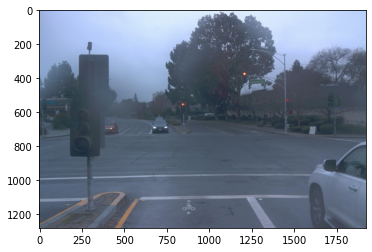

In [42]:
print(len(filenames))

index = random.randint(0, 65453)
fname = filenames[index]
print(fname)

image_path = f"../../../datasets/Waymo/dataset/train/{fname}.jpg"
print(image_path)

img = plt.imread(image_path)
# plt.figure(figsize=(15,18))
plt.imshow(img)
plt.show()

In [88]:
for i in range(len(filenames)):
    fname = filenames[i]
    image_path = f"../../../datasets/Waymo/dataset/train/{fname}.jpg"
    
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image_size = original_image.shape[:2]

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    
    pred_bbox = model.predict(image_data)
    
    hint_100_256 = pred_bbox[3]
    hint_200_128 = pred_bbox[4]
    
    np.save(f'./hint_features/yolov4/100x100x256/{fname}.npy', hint_100_256) # save
    np.save(f'./hint_features/yolov4/200x200x128/{fname}.npy', hint_200_128) # save
    
    print(i, fname)

0 tr23-19-11-4-SIDE_LEFT
1 tr11-25-8-2-FRONT_LEFT
2 tr25-19-7-5-SIDE_RIGHT
3 tr29-13-3-1-FRONT
4 tr07-12-14-5-SIDE_RIGHT
5 tr28-17-13-5-SIDE_RIGHT
6 tr16-20-3-4-SIDE_LEFT
7 tr27-25-3-1-FRONT
8 tr29-9-1-1-FRONT
9 tr25-24-10-2-FRONT_LEFT
10 tr10-19-10-1-FRONT
11 tr01-20-2-2-FRONT_LEFT
12 tr11-14-14-1-FRONT
13 tr04-19-4-1-FRONT
14 tr23-10-13-4-SIDE_LEFT
15 tr23-2-20-2-FRONT_LEFT
16 tr29-8-17-5-SIDE_RIGHT
17 tr27-15-17-4-SIDE_LEFT
18 tr25-6-8-2-FRONT_LEFT
19 tr15-14-1-5-SIDE_RIGHT
20 tr24-5-17-1-FRONT
21 tr21-24-7-4-SIDE_LEFT
22 tr09-18-18-1-FRONT
23 tr11-25-5-4-SIDE_LEFT
24 tr20-25-15-3-FRONT_RIGHT
25 tr01-4-9-5-SIDE_RIGHT
26 tr28-22-9-1-FRONT
27 tr28-12-4-1-FRONT
28 tr16-7-6-1-FRONT
29 tr22-19-19-2-FRONT_LEFT
30 tr04-4-16-1-FRONT
31 tr15-7-16-1-FRONT
32 tr30-2-6-1-FRONT
33 tr13-4-8-4-SIDE_LEFT
34 tr14-10-11-3-FRONT_RIGHT
35 tr19-16-9-4-SIDE_LEFT
36 tr12-8-15-5-SIDE_RIGHT
37 tr08-22-2-1-FRONT
38 tr14-9-5-4-SIDE_LEFT
39 tr08-19-3-1-FRONT
40 tr03-18-12-2-FRONT_LEFT
41 tr06-13-18-5-SIDE_RIGH

KeyboardInterrupt: 

In [86]:
fname = "tr11-14-14-1-FRONT"
new_num_arr = np.load(f'./hint_features/yolov4/100x100x256/{fname}.npy')
print(new_num_arr.shape)
print(new_num_arr)

(1, 100, 100, 256)
[[[[ 0.54083025  1.9309341  -0.23502487 ...  0.97879946 -0.30525434
    -0.27995163]
   [ 1.9163222   2.4625652  -0.30790535 ... -0.2932774   1.3052392
    -0.1306784 ]
   [ 1.9699876   2.9635172  -0.21476574 ... -0.30138722  1.6178657
    -0.1072672 ]
   ...
   [ 1.5886357   3.2623632  -0.16031963 ... -0.3080553   1.2242036
    -0.08019342]
   [ 1.5487207   2.925078   -0.25651112 ... -0.19587086  0.4026955
    -0.06028182]
   [ 1.7195842   2.8700607  -0.22945684 ... -0.17412806 -0.27166048
    -0.1372102 ]]

  [[-0.03642542  0.382158    0.8338696  ...  2.3598135  -0.30808726
     1.6859225 ]
   [ 0.59641296  0.77780646 -0.18036957 ... -0.13115719 -0.29432598
    -0.10022748]
   [ 1.2869239  -0.01752394 -0.2422619  ... -0.11176743 -0.20010595
    -0.21596716]
   ...
   [ 0.68694854 -0.14477594 -0.20990717 ... -0.094859   -0.1739404
    -0.25660875]
   [ 0.50479436 -0.260251   -0.06780223 ... -0.02919602 -0.10929851
    -0.2946651 ]
   [ 0.41539422  2.8662715  -0.0533